In [1]:
import nltk
nltk.download('punkt')

import tensorflow as tf
import numpy as np

from sklearn.metrics import classification_report, auc, precision_recall_curve

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling1D, Conv1D, concatenate, Embedding, Input, Add, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load IMDB Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    path='imdb.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3)


word_index = tf.keras.datasets.imdb.get_word_index()
start_char = 1
oov_char = 2


inverted_word_index = dict((i + 3, word) for (word, i) in word_index.items())

inverted_word_index[start_char] = '[START]'
inverted_word_index[oov_char] = '[OOV]'

for i in range(len(x_train)):
  x_train[i] = ' '.join(inverted_word_index[i] for i in x_train[i])

for i in range(len(x_test)):
  x_test[i] = ' '.join(inverted_word_index[i] for i in x_test[i])



# Split the dataset to training, development and test set
  
x_train = np.concatenate((x_train, x_test[10000:]))
y_train = np.concatenate((y_train, y_test[10000:]))

x_dev = x_train[:10000]
y_dev = y_train[:10000]

x_train = x_train[10000:]
y_train = y_train[10000:]

x_test = x_test[:10000]
y_test = y_test[:10000]

print('\nTraining set shape :', x_train.shape)
print('Development set shape :', x_dev.shape)
print('Test set shape :', x_test.shape)



# Calculate average document length

def average_doc_length(docs_tokenized):
  doc_sizes = []

  for doc in docs_tokenized:
    doc_sizes.append(len(doc))

  return int(np.mean(np.array(doc_sizes)))



# Tokenize each document (start from 3rd index because of pseudotokens)

x_train_tokenized = [nltk.tokenize.word_tokenize(doc)[3:] for doc in x_train]
x_dev_tokenized = [nltk.tokenize.word_tokenize(doc)[3:] for doc in x_dev]
x_test_tokenized = [nltk.tokenize.word_tokenize(doc)[3:] for doc in x_test]

print('\nAverage doc length of training set :', average_doc_length(x_train_tokenized))
print('Average doc length of development set :', average_doc_length(x_dev_tokenized))
print('Average doc length of test set :', average_doc_length(x_test_tokenized))

1641221/1641221 [==============================] - 0s 0us/step

Training set shape : (30000,)
Development set shape : (10000,)
Test set shape : (10000,)

Average doc length of training set : 238
Average doc length of development set : 242
Average doc length of test set : 234


In [3]:
# Set the target class names

target_names = ['negative', 'positive']


# Print an element of the set

print(x_train_tokenized[0])

['i', 'think', 'this', 'is', 'one', 'of', 'the', 'weakest', 'of', 'the', 'kenneth', 'branagh', 'shakespearian', 'works', 'after', 'such', 'great', 'efforts', 'as', 'much', 'ado', 'about', 'nothing', 'etc', 'i', 'thought', 'this', 'was', 'poor', 'the', 'cast', 'was', 'weaker', 'alicia', 'silverstone', 'nivoli', 'mcelhone', 'but', 'my', 'biggest', 'gripe', 'was', 'that', 'they', 'messed', 'with', 'the', 'bard', "'s", 'work', 'and', 'cut', 'out', 'some', 'of', 'the', 'play', 'to', 'put', 'in', 'the', 'musical', 'dance', 'sequences', 'br', 'br', 'you', 'just', 'do', "n't", 'do', 'shakespeare', 'and', 'then', 'mess', 'with', 'the', 'play', 'sorry', 'but', 'that', 'is', 'just', 'wrong', 'i', 'love', 'some', 'cole', 'porter', 'just', 'like', 'the', 'next', 'person', 'but', 'jeez', 'do', "n't", 'mess', 'with', 'the', 'shakespeare', 'skip', 'this', 'and', 'watch', 'prospero', "'s", 'books', 'if', 'you', 'want', 'to', 'see', 'a', 'brilliant', 'shakespearean', 'adaptation', 'of', 'the', 'tempest'

# Indexing and embedding

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api


embeddings = api.load('glove-wiki-gigaword-100')


MAX_SEQUENCE_LENGTH = 200
MAX_WORDS = 60000


tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='__UNK__')
tokenizer.fit_on_texts([" ".join(x) for x in x_train_tokenized])


# Convert text to sequences of IDs

train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_train_tokenized])
dev_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_dev_tokenized])
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_test_tokenized])


# Pad the sequences for the fixed input size

train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
dev_data = pad_sequences(dev_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


# Print an element of the set

print(train_data[0])

[==================================================] 100.0% 128.1/128.1MB downloaded
[   11   106    12     7    31     5     2  4616     5     2  4927  4507
 14662   510   104   142    84  1971    16    77 18737    47   164   484
    11   191    12    15   339     2   178    15  6776  8620 17318 47414
 24484    20    61  1092 10257    15    13    34  5175    19     2 15554
    14   162     3   569    46    51     5     2   284     6   271    10
     2   661   834   822     8     8    22    43    44    24    44  1754
     3    97   925    19     2   284   733    20    13     7    43   362
    11   117    51  3824  5786    43    39     2   370   393    20 18022
    44    24   925    19     2  1754  1779    12     3   107 13058    14
  1161    48    22   179     6    66     4   515  8016  1346     5     2
  9513     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   

In [5]:
# Filter out some rare tokens

word_index = tokenizer.word_index

print('Found {} unique tokens.\n'.format(len(word_index)))
print(f'We will only use {MAX_WORDS} of these')
print(list(word_index.items())[:10])
print('We will filter these out')
print(list(word_index.items())[MAX_WORDS+5:MAX_WORDS+20])
print(len(list(word_index.items())))

Found 66804 unique tokens.

We will only use 60000 of these
[('__UNK__', 1), ('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('br', 8), ('it', 9), ('in', 10)]
We will filter these out
[('sanata', 60006), ('missfortune', 60007), ("'next", 60008), ("'prize", 60009), ("'gotcha", 60010), ('pleeease', 60011), ('schlessinger', 60012), ('marketers', 60013), ('miaows', 60014), ('diage', 60015), ('barzell', 60016), ('gillia', 60017), ('podunk', 60018), ('deputize', 60019), ('unflagging', 60020)]
66804


In [6]:
EMBEDDING_DIM = 100


# +2 for 'pad' and 'unk' tokens

embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))


# Create embeddings matrix based on our word index

count = 0
for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_matrix[i] = embeddings[word]
        count += 1
    except:
        pass


# Check that every token has an embedding
    
print(len(np.unique(np.nonzero(embedding_matrix)[0])))
print(count)

del embeddings
del word_index
del tokenizer

50730
50730


# Model creation and hyper-parameter tuning

In [7]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.1 MB/s eta 0:00:00


In [8]:
# Initialize some hyperparameters

BATCH_SIZE = 64
EPOCHS = 15
FILTERS = EMBEDDING_DIM


import keras_tuner as kt


def model_builder(hp):


  # Hyperparameters to tune
  
  hp_stack = hp.Int('stacks', min_value=1, max_value=3, step=1)
  hp_dropout = hp.Float('rate', min_value=0.1, max_value=0.5, step=0.2)
  hp_learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=0.1, step=10, sampling='log')


  inputs = Input((MAX_SEQUENCE_LENGTH,))


  # Embedding layer

  embeddings = Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)

  x = Dropout(rate=hp_dropout)(embeddings)


  # Multi-filter CNNs

  pooled_convs = []
  filter_sizes = [2,3,4]

  for n_gram in filter_sizes:

    fx = Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, activation='relu', padding='same', name='{}-gram_Convolutions{}'.format(n_gram, 1))(x)

    for i in range(1, hp_stack):

      input = fx


      # Stack CNNs

      fx = Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, activation='relu', padding='same', name='{}-gram_Convolutions{}'.format(n_gram, i+1))(input)


      # Maybe use some residual connections, batch normalization and a relu layer to combine them

      fx = Add()([input,fx])
      # fx = BatchNormalization()(fx)
      # fx = ReLU()(fx)


    # Max-Pooling over time
    pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(fx))


  concat = concatenate(pooled_convs)

  drop_x = Dropout(rate=hp_dropout)(concat)

  out = Dense(1, activation="sigmoid")(drop_x)


  model = Model(inputs=inputs, outputs=out)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(
                from_logits=False),
                optimizer=Adam(learning_rate=hp_learning_rate),
                metrics=["accuracy"])

  return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=EPOCHS,
                     factor=3,
                     directory='my_dir7',
                     project_name='intro_to_kt')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


# Give a subset of the datasets in order to save time

tuner.search(train_data[:10000], y_train[:10000], epochs=10, validation_data=(dev_data[:2000], y_dev[:2000]), callbacks=[stop_early], batch_size=BATCH_SIZE)


# Get the optimal hyperparameters

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. We stacked {best_hps.get('stacks')} CNNs. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the dropout probability is: {best_hps.get('rate')}.
""")

Trial 30 Complete [00h 13m 25s]
val_accuracy: 0.8335000276565552

Best val_accuracy So Far: 0.8675000071525574
Total elapsed time: 02h 04m 36s

The hyperparameter search is complete. We stacked 3 CNNs. The optimal learning rate for the optimizer
is 0.001 and the dropout probability is: 0.1.



In [9]:
# Print the best model

model = tuner.hypermodel.build(best_hps)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 200, 100)             6000200   ['input_2[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 200, 100)             0         ['embedding_1[0][0]']         
                                                                                                  
 2-gram_Convolutions1 (Conv  (None, 200, 100)             20100     ['dropout_2[0][0]']           
 1D)                                                                                        

Epoch 1/15
469/469 [==============================] - 284s 605ms/step - loss: 0.4899 - accuracy: 0.7556 - val_loss: 0.3520 - val_accuracy: 0.8490
Epoch 2/15
469/469 [==============================] - 264s 564ms/step - loss: 0.3433 - accuracy: 0.8488 - val_loss: 0.3155 - val_accuracy: 0.8648
Epoch 3/15
469/469 [==============================] - 269s 573ms/step - loss: 0.3004 - accuracy: 0.8707 - val_loss: 0.3057 - val_accuracy: 0.8683
Epoch 4/15
469/469 [==============================] - 264s 563ms/step - loss: 0.2669 - accuracy: 0.8896 - val_loss: 0.3467 - val_accuracy: 0.8488
Epoch 5/15
469/469 [==============================] - 266s 568ms/step - loss: 0.2434 - accuracy: 0.8977 - val_loss: 0.2875 - val_accuracy: 0.8809
Epoch 6/15
469/469 [==============================] - 266s 567ms/step - loss: 0.2210 - accuracy: 0.9091 - val_loss: 0.2770 - val_accuracy: 0.8871
Epoch 7/15
469/469 [==============================] - 267s 569ms/step - loss: 0.1888 - accuracy: 0.9254 - val_loss: 0.2788 -

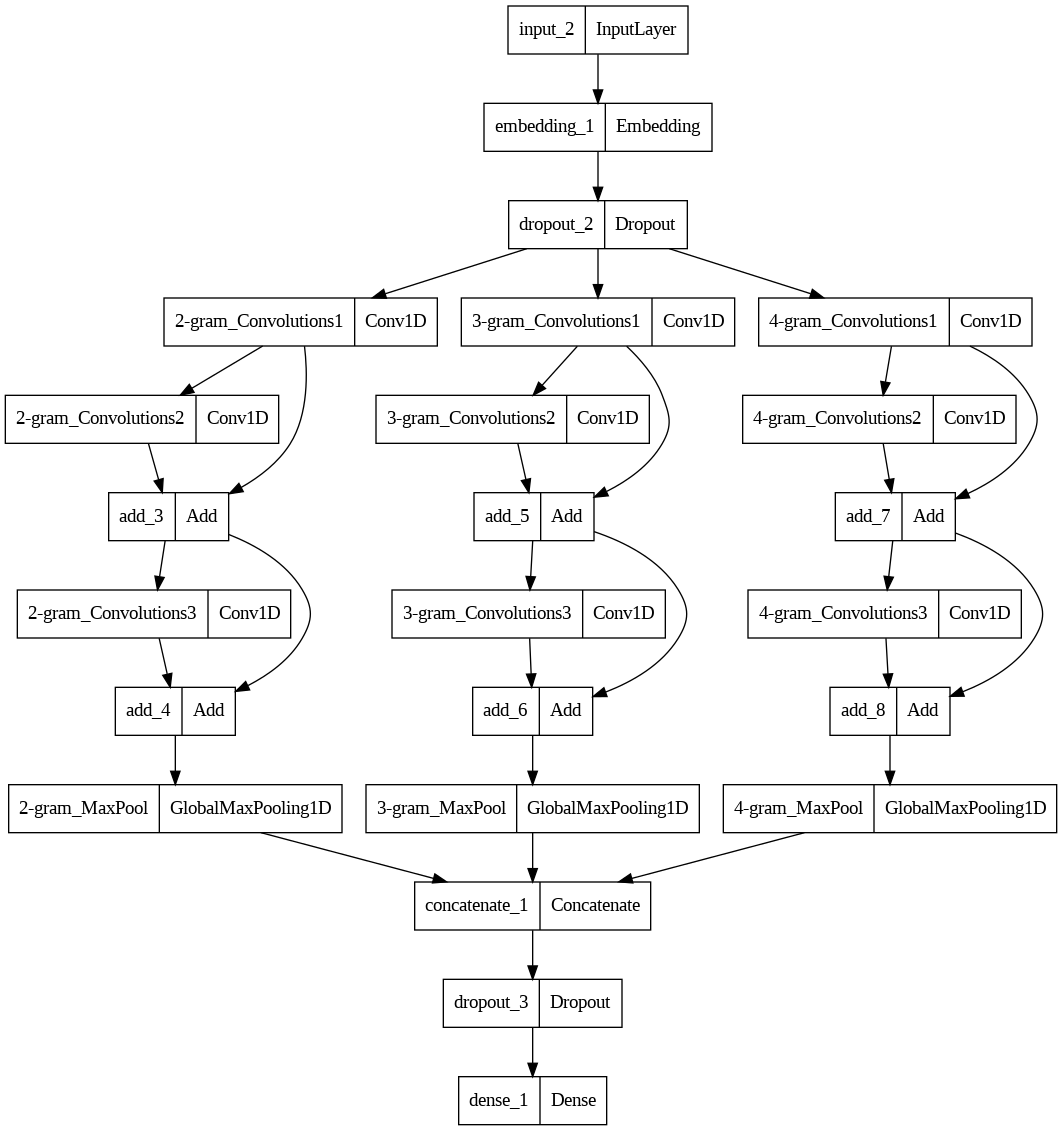

In [11]:
# Train the best model with the full datasets

import time

with tf.device('/device:GPU:0'):

  start_training_time = time.time()

  history = model.fit(train_data,
                    y_train,
                    validation_data=(dev_data, y_dev),
                    batch_size=BATCH_SIZE,
                    epochs=15,
                    shuffle=True)

  end_training_time = time.time()

  print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


%matplotlib notebook

# Print a diagram of the model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image
Image('model.png')

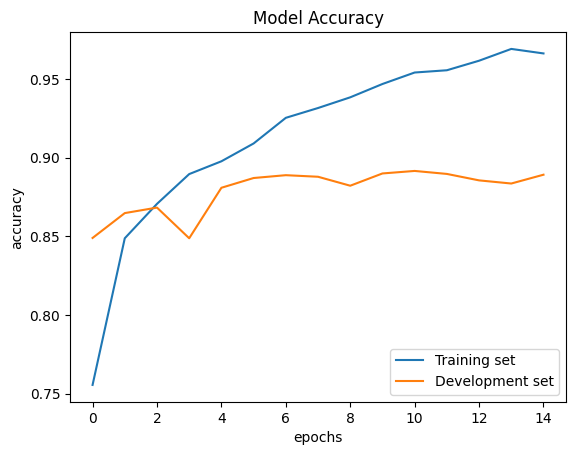

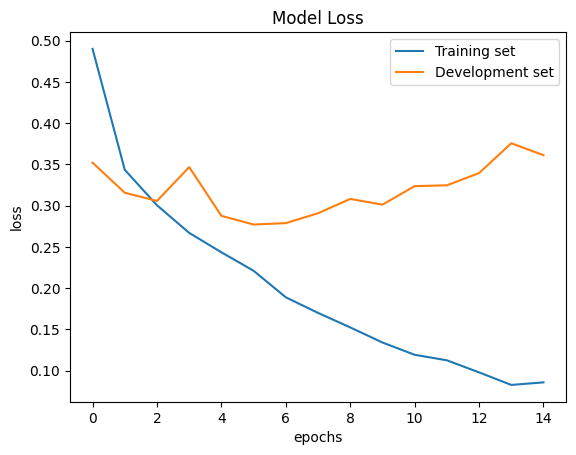

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt


# Print accuracy and loss plots (from the plots we see that we should try lower values for learning rate in the tuning sector)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='lower right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='upper right')
plt.show()

# Metrics

Precision , Recall , F1 , AUC scores for CNN classifier

In [13]:
# Print some other metrics (Precision, Recall, F1, AUC) scores for each dataset

model = tuner.hypermodel.build(best_hps)
model.fit(train_data, y_train, validation_data=(dev_data, y_dev), batch_size=BATCH_SIZE, epochs=best_epoch, shuffle=True)


cnn_predictions_train = model.predict(train_data)
cnn_precision_train, cnn_recall_train, thresholds = precision_recall_curve(y_train, cnn_predictions_train)

cnn_predictions_dev = model.predict(dev_data)
cnn_precision_dev, cnn_recall_dev, thresholds = precision_recall_curve(y_dev, cnn_predictions_dev)

cnn_predictions_test = model.predict(test_data)
cnn_precision_test, cnn_recall_test, thresholds = precision_recall_curve(y_test, cnn_predictions_test)


print('\n--------- Custom stacked CNN ---------\n')
print('Training set\n')
print(classification_report(y_train, np.round(cnn_predictions_train), target_names = target_names))
print('AUC training :', auc(cnn_recall_train, cnn_precision_train), '\n')
print('\nDevelopment set\n')
print(classification_report(y_dev, np.round(cnn_predictions_dev), target_names = target_names))
print('AUC development :', auc(cnn_recall_dev, cnn_precision_dev), '\n')
print('\nTest set\n')
print(classification_report(y_test, np.round(cnn_predictions_test), target_names = target_names))
print('AUC test :', auc(cnn_recall_test, cnn_precision_test))

Epoch 1/6
469/469 [==============================] - 266s 563ms/step - loss: 0.4883 - accuracy: 0.7597 - val_loss: 0.3897 - val_accuracy: 0.8251
Epoch 2/6
469/469 [==============================] - 259s 554ms/step - loss: 0.3406 - accuracy: 0.8506 - val_loss: 0.3775 - val_accuracy: 0.8333
Epoch 3/6
469/469 [==============================] - 258s 550ms/step - loss: 0.3054 - accuracy: 0.8688 - val_loss: 0.2997 - val_accuracy: 0.8726
Epoch 4/6
469/469 [==============================] - 256s 546ms/step - loss: 0.2653 - accuracy: 0.8872 - val_loss: 0.2784 - val_accuracy: 0.8820
Epoch 5/6
469/469 [==============================] - 240s 512ms/step - loss: 0.2337 - accuracy: 0.9024 - val_loss: 0.2747 - val_accuracy: 0.8831
Epoch 6/6
313/313 [==============================] - 23s 74ms/step

--------- Custom stacked CNN ---------

Training set

              precision    recall  f1-score   support

    negative       0.98      0.92      0.95     15026
    positive       0.92      0.98      0.95 